In [37]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import GRU
from sklearn.model_selection import train_test_split
from keras.src.layers import TextVectorization, Dropout
from sklearn.preprocessing import OneHotEncoder
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense

In [38]:
df = pd.read_csv("train.csv", names=['Class_index', 'title', 'description'])
df.head()

,Class_index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [39]:
df["title_description"] = df["title"] + df["description"]
df = df.drop(["title", "description"], axis=1)
df.head()

,Class_index,title_description
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [40]:
df['Class_Index'] = df['Class_index'].map({
    1: 'politics',
    2: 'sports',
    3: 'technology',
    4: 'entertainment'
})
df.drop('Class_index', axis=1, inplace=True)
df.head()

,title_description,Class_Index
0,Wall St. Bears Claw Back Into the Black (Reute...,technology
1,Carlyle Looks Toward Commercial Aerospace (Reu...,technology
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,technology
3,Iraq Halts Oil Exports from Main Southern Pipe...,technology
4,"Oil prices soar to all-time record, posing new...",technology


In [41]:
df_sample = df.sample(1000, random_state=42)

In [42]:
N = 15000
T = 50
# Textos de entrada
textos = df_sample["title_description"].astype(str).tolist()  # Aseguramos que todo es string

# Parámetros
max_tokens = N        # Número máximo de palabras en el vocabulario
output_sequence_length = T  # Longitud fija de la secuencia

# Capa TextVectorization
vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length,
    standardize='lower_and_strip_punctuation',
)

# Adaptamos al texto
vectorize_layer.adapt(textos)

# Aplicamos la vectorización
X = vectorize_layer(tf.constant(textos))

# Si necesitas como NumPy array
X = X.numpy()

# La variable objetivo
y = df_sample["Class_Index"].values  # O la columna que estés usando como etiqueta

In [43]:
y.shape

(1000,)

In [44]:
# First get the corresponding one-hot labels from df_codificado


encoder = OneHotEncoder(sparse_output=False)

categoricas = ['Class_Index']
valores = encoder.fit_transform(df[categoricas])

columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)
y = df_codificado.loc[df_sample.index].values
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)
df.head()

,title_description,Class_Index_entertainment,Class_Index_politics,Class_Index_sports,Class_Index_technology
0,Wall St. Bears Claw Back Into the Black (Reute...,0.0,0.0,0.0,1.0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,0.0,0.0,0.0,1.0
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,0.0,0.0,0.0,1.0
3,Iraq Halts Oil Exports from Main Southern Pipe...,0.0,0.0,0.0,1.0
4,"Oil prices soar to all-time record, posing new...",0.0,0.0,0.0,1.0


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [46]:
N = 15000
T = 50

model = Sequential([
    Input(shape=(T,)),
    Embedding(input_dim=N+2, output_dim=T),
    GRU(units=32, return_sequences=False),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 50)         │       750,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 32)             │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,296 (2.89 MB)

 Trainable params: 758,296 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=8, batch_size=64, verbose=1)

Epoch 1/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.2548 - loss: 1.3868 - val_accuracy: 0.2500 - val_loss: 1.3858
Epoch 2/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.2694 - loss: 1.3795 - val_accuracy: 0.2500 - val_loss: 1.3858
Epoch 3/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.2630 - loss: 1.3816 - val_accuracy: 0.2500 - val_loss: 1.3859
Epoch 4/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2788 - loss: 1.3816 - val_accuracy: 0.2500 - val_loss: 1.3853
Epoch 5/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3286 - loss: 1.3761 - val_accuracy: 0.2438 - val_loss: 1.3855
Epoch 6/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3295 - loss: 1.3738 - val_accuracy: 0.2562 - val_loss: 1.3851
Epoch 7/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.3385 - loss: 1.3707 - val_accuracy: 0.2562 - val_loss: 1.3853
Epoch 8/8
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3247 - loss: 1.3678 - val_accuracy: 0.2562 - val_loss:

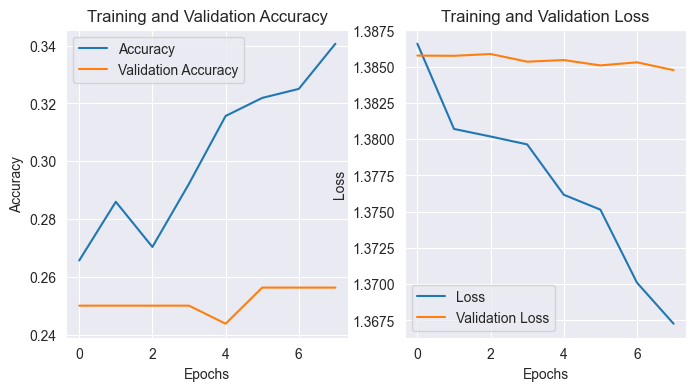

In [48]:
# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [49]:
joblib.dump(encoder, 'encoder.joblib')
joblib.dump(model, 'modelo.joblib')

['modelo.joblib']